# Import packages

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn import linear_model, metrics
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy
import warnings

## Get list of S&P 500 stocks

In [2]:
# Get the list of S&P 500 stocks
sp500_stocks = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol'].tolist()
print(sp500_stocks)

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BK', 'BBWI', 'BAX', 'BDX', 'BRK.B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BX', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BLDR', 'BG', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CDAY', 'CF', 'CHRW', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CCI', 'CSX', 'CMI', 'C

In [3]:
# Set the start date and end date of previous data
date_today = str(datetime.date.today())
date_from_4_years = str(datetime.date.today() - datetime.timedelta(days=4*365))
date_yesterday = str(datetime.date.today() - datetime.timedelta(days=1))

## Get Historical Technical Data

In [4]:
# Loop through the first 5 tickers and get historical data
technical_df = pd.DataFrame()
for stock in sp500_stocks:
    try:
        # Get historical data for the current ticker from the past 2 years
        stock_historical_data = yf.download(stock, start=date_from_4_years, end=date_today, progress=False)
        # Add a new column for the stock symbol
        stock_historical_data['Symbol'] = stock
        technical_df = pd.concat([technical_df, stock_historical_data])
    except Exception as e:
        print(f"Error retrieving data for {stock}: {e}")


1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
C:\Users\Adham\AppData\Local\Temp\ipykernel_7888\704201189.py:9: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  technical_df = pd.concat([technical_df, stock_historical_data])

1 Failed download:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2020-01-06 -> 2024-01-05)')
C:\Users\Adham\AppData\Local\Temp\ipykernel_7888\704201189.py:9: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  technical_df = pd.concat([technical_df, stock_histo

In [5]:
# Display the dataframe without breaking in separate line
pd.set_option('display.expand_frame_repr', False)

In [6]:
# Make "Date" a normal column instead of index as it has duplicates.
technical_df = technical_df.reset_index()

In [7]:
print(len(technical_df))

501103


In [8]:
print(technical_df.tail())

             Date        Open        High         Low       Close   Adj Close     Volume Symbol
500548 2023-12-11  185.169998  190.149994  184.679993  189.460007  189.460007  3199200.0    ZTS
500549 2023-12-12  190.080002  192.500000  188.919998  191.470001  191.470001  1899700.0    ZTS
500550 2023-12-13  191.779999  197.669998  190.940002  197.410004  197.410004  2104700.0    ZTS
500551 2023-12-14  198.000000  201.919998  198.000000  200.089996  200.089996  3044400.0    ZTS
500552 2023-12-15  199.410004  199.410004  193.970001  196.289993  196.289993  4058300.0    ZTS


In [9]:
print(technical_df.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Symbol'],
      dtype='object')


## Get Yesterday's Technical Data

In [ ]:
yesterday_technical_df = pd.DataFrame()
for stock in sp500_stocks:
    try:
        # Download technical data for yesterday
        data = yf.download(stock, start=date_yesterday, end=date_today, progress=False)
        data['Symbol'] = stock
        yesterday_technical_df = pd.concat([yesterday_technical_df, data])
    except Exception as e:
        print(f"Error retrieving data for {stock}: {e}")

In [119]:
yesterday_technical_df.reset_index(inplace=True)

In [85]:
print(len(yesterday_technical_df))

501


In [120]:
print(yesterday_technical_df.tail())

          Date        Open        High         Low       Close   Adj Close     Volume Symbol
496 2023-10-27  119.040001  120.250000  118.279999  119.440002  119.440002  2330633.0    YUM
497 2023-10-27  204.600006  207.559998  201.160004  207.179993  207.179993   565000.0   ZBRA
498 2023-10-27  104.000000  104.809998  102.709999  103.190002  103.190002  1534500.0    ZBH
499 2023-10-27   30.590000   30.670000   28.980000   29.450001   29.450001  2498300.0   ZION
500 2023-10-27  157.929993  157.932007  155.160004  156.029999  156.029999  2406212.0    ZTS


## Get Historical Fundamental Data

In [7]:
selected_income_statement_columns = ['Basic EPS', 'Net Income', 'Total Revenue', 'Total Expenses']
selected_balance_sheet_columns = ['Total Debt', 'Total Capitalization', 'Total Assets']
selected_cash_flow_columns = ['Free Cash Flow', 'Capital Expenditure']

In [8]:
fundamental_df = pd.DataFrame()
for stock in sp500_stocks:
    try:
        stock_ticker = yf.Ticker(stock)
        # Get income statement
        income_statement = stock_ticker.income_stmt.transpose()
        # Get balance sheet
        balance_sheet = stock_ticker.balance_sheet.transpose()
        # Get cash flow
        cash_flow = stock_ticker.cash_flow.transpose()
        # Merge the different fundamental data sources
        stock_fundamental_data = pd.merge(income_statement[selected_income_statement_columns], balance_sheet[selected_balance_sheet_columns], left_index=True, right_index=True)
        stock_fundamental_data = pd.merge(stock_fundamental_data, cash_flow[selected_cash_flow_columns], left_index=True, right_index=True)
        # Add a new column for the stock symbol
        stock_fundamental_data['Symbol'] = stock
        stock_fundamental_data = stock_fundamental_data.resample('D').ffill()
        stock_fundamental_data = stock_fundamental_data[(stock_fundamental_data.index >= date_from_4_years) & (stock_fundamental_data.index <= date_today)]
        fundamental_df = pd.concat([fundamental_df, stock_fundamental_data])
    except Exception as e:
        print(f"Error retrieving data for {stock}: {e}")

Error retrieving data for AFL: "['Capital Expenditure'] not in index"
Error retrieving data for ARE: "['Capital Expenditure'] not in index"
Error retrieving data for LNT: "['Capital Expenditure'] not in index"
Error retrieving data for AXP: "['Total Expenses'] not in index"
Error retrieving data for AIG: "['Capital Expenditure'] not in index"
Error retrieving data for BAC: "['Total Expenses'] not in index"
Error retrieving data for BK: "['Total Expenses'] not in index"
Error retrieving data for BRK.B: "None of [Index(['Basic EPS', 'Net Income', 'Total Revenue', 'Total Expenses'], dtype='object')] are in the [columns]"
Error retrieving data for BX: "['Total Expenses'] not in index"
Error retrieving data for BXP: "['Capital Expenditure'] not in index"
Error retrieving data for BF.B: "None of [Index(['Basic EPS', 'Net Income', 'Total Revenue', 'Total Expenses'], dtype='object')] are in the [columns]"
Error retrieving data for COF: "['Total Expenses'] not in index"
Error retrieving data fo

In [9]:
# Rename index to be "Date" then convert it to a normal column as it has duplicates
fundamental_df.reset_index(inplace=True)
fundamental_df.rename(columns={'index': 'Date'}, inplace=True)
fundamental_df['Date'] = pd.to_datetime(fundamental_df['Date'])

In [10]:
print(len(fundamental_df))

372042


In [14]:
print(fundamental_df.tail())

             Date Basic EPS    Net Income Total Revenue Total Expenses    Total Debt Total Capitalization   Total Assets Free Cash Flow Capital Expenditure Symbol
497208 2022-12-27      4.29  2037000000.0  7776000000.0   4973000000.0  6743000000.0        11135000000.0  13900000000.0   1736000000.0        -477000000.0    ZTS
497209 2022-12-28      4.29  2037000000.0  7776000000.0   4973000000.0  6743000000.0        11135000000.0  13900000000.0   1736000000.0        -477000000.0    ZTS
497210 2022-12-29      4.29  2037000000.0  7776000000.0   4973000000.0  6743000000.0        11135000000.0  13900000000.0   1736000000.0        -477000000.0    ZTS
497211 2022-12-30      4.29  2037000000.0  7776000000.0   4973000000.0  6743000000.0        11135000000.0  13900000000.0   1736000000.0        -477000000.0    ZTS
497212 2022-12-31      4.51  2114000000.0  8080000000.0   5152000000.0  8090000000.0        10957000000.0  14925000000.0   1326000000.0        -586000000.0    ZTS


## Get Yesterday's Fundamental Data

In [121]:
yesterday_fundamental_df = pd.DataFrame()
for stock in sp500_stocks:
    try:
        stock_ticker = yf.Ticker(stock)
        # Get quarterly income statement
        quarterly_income_statement = stock_ticker.quarterly_incomestmt.transpose().head(1)
        # Get quarterly balance sheet
        quarterly_balance_sheet = stock_ticker.quarterly_balance_sheet.transpose().head(1)
        # Get quarterly cash flow
        quarterly_cash_flow = stock_ticker.quarterly_cashflow.transpose().head(1)
        # Merge the different fundamental data sources
        data = pd.merge(quarterly_income_statement[selected_income_statement_columns], quarterly_balance_sheet[selected_balance_sheet_columns], left_index=True, right_index=True)
        data = pd.merge(data, quarterly_cash_flow[selected_cash_flow_columns], left_index=True, right_index=True)
        # Add a new column for the stock symbol
        data['Symbol'] = stock
        data['Date'] = date_yesterday
        # Concat to the final dataframe
        yesterday_fundamental_df = pd.concat([yesterday_fundamental_df, data])
    except Exception as e:
        print(f"Error retrieving data for {stock}: {e}")

yesterday_fundamental_df.reset_index(inplace=True, drop=True)

Error retrieving data for AFL: "['Capital Expenditure'] not in index"
Error retrieving data for ARE: "['Capital Expenditure'] not in index"
Error retrieving data for LNT: "['Capital Expenditure'] not in index"
Error retrieving data for AXP: "['Total Expenses'] not in index"
Error retrieving data for AIG: "['Capital Expenditure'] not in index"
Error retrieving data for BAC: "['Total Expenses'] not in index"
Error retrieving data for BRK.B: "None of [Index(['Basic EPS', 'Net Income', 'Total Revenue', 'Total Expenses'], dtype='object')] are in the [columns]"
Error retrieving data for BX: "['Total Expenses'] not in index"
Error retrieving data for BK: "['Total Expenses'] not in index"
Error retrieving data for BXP: "['Capital Expenditure'] not in index"
Error retrieving data for BF.B: "None of [Index(['Basic EPS', 'Net Income', 'Total Revenue', 'Total Expenses'], dtype='object')] are in the [columns]"
Error retrieving data for COF: "['Total Expenses'] not in index"
Error retrieving data fo

In [122]:
print(len(yesterday_fundamental_df))

428


In [123]:
print(yesterday_fundamental_df.tail())

    Basic EPS   Net Income Total Revenue Total Expenses     Total Debt Total Capitalization   Total Assets Free Cash Flow Capital Expenditure Symbol        Date
423      0.45   92000000.0  1722000000.0   1575000000.0   2267000000.0        12166000000.0  16097000000.0    -26000000.0         -54000000.0    XYL  2023-10-27
424      1.49  418000000.0  1687000000.0   1125000000.0  11568000000.0         2758000000.0   5848000000.0    264000000.0         -60000000.0    YUM  2023-10-27
425       2.8  144000000.0  1214000000.0   1004000000.0   2365000000.0         5034000000.0   7456000000.0    -52000000.0         -18000000.0   ZBRA  2023-10-27
426       1.0  209600000.0  1869600000.0   1507600000.0   5709400000.0        17568000000.0  21294300000.0    177300000.0        -170600000.0    ZBH  2023-10-27
427      1.45  671000000.0  2180000000.0   1346000000.0   6745000000.0        11180000000.0  13749000000.0     17000000.0        -166000000.0    ZTS  2023-10-27


## Merge Technical and Fundamental Data

In [11]:
sp500_df = pd.merge(technical_df, fundamental_df, on=["Date", "Symbol"])

In [12]:
# Set index to Date column
sp500_df = sp500_df.set_index(['Date'])

In [17]:
print(sp500_df.head())

                  Open        High         Low       Close   Adj Close     Volume Symbol Basic EPS    Net Income  Total Revenue Total Expenses     Total Debt Total Capitalization   Total Assets Free Cash Flow Capital Expenditure
Date                                                                                                                                                                                                                                
2019-12-31  175.229996  176.589996  175.070007  176.419998  149.132584  1573500.0    MMM      7.92  4570000000.0  32136000000.0  26076000000.0  20560000000.0        27644000000.0  44659000000.0   5371000000.0       -1699000000.0
2020-01-02  177.679993  180.009995  177.139999  180.000000  152.158829  3601700.0    MMM      7.92  4570000000.0  32136000000.0  26076000000.0  20560000000.0        27644000000.0  44659000000.0   5371000000.0       -1699000000.0
2020-01-03  177.020004  178.660004  175.630005  178.449997  150.848587  2466900.0   

In [18]:
print(len(sp500_df))

340903


In [19]:
print(sp500_df.shape)

(340903, 16)


In [20]:
sp500_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 340903 entries, 2019-12-31 to 2022-12-30
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Open                  340903 non-null  float64
 1   High                  340903 non-null  float64
 2   Low                   340903 non-null  float64
 3   Close                 340903 non-null  float64
 4   Adj Close             340903 non-null  float64
 5   Volume                340903 non-null  float64
 6   Symbol                340903 non-null  object 
 7   Basic EPS             340895 non-null  object 
 8   Net Income            340903 non-null  object 
 9   Total Revenue         340903 non-null  object 
 10  Total Expenses        340903 non-null  object 
 11  Total Debt            338884 non-null  object 
 12  Total Capitalization  340903 non-null  object 
 13  Total Assets          340903 non-null  object 
 14  Free Cash Flow        340903 non-nul

In [13]:
# Change data types from object to float
sp500_df['Basic EPS'] = sp500_df['Basic EPS'].astype('float64')
sp500_df['Net Income'] = sp500_df['Net Income'].astype('float64')
sp500_df['Total Revenue'] = sp500_df['Total Revenue'].astype('float64')
sp500_df['Total Expenses'] = sp500_df['Total Expenses'].astype('float64')
sp500_df['Total Debt'] = sp500_df['Total Debt'].astype('float64')
sp500_df['Total Capitalization'] = sp500_df['Total Capitalization'].astype('float64')
sp500_df['Total Assets'] = sp500_df['Total Assets'].astype('float64')
sp500_df['Free Cash Flow'] = sp500_df['Free Cash Flow'].astype('float64')
sp500_df['Capital Expenditure'] = sp500_df['Capital Expenditure'].astype('float64')

In [14]:
# Reorder columns
sp500_df = sp500_df[['Symbol', 'Open', 'High', 'Low', 'Adj Close', 'Volume', 'Basic EPS', 
                     'Net Income', 'Total Revenue', 'Total Expenses', 'Total Debt', 'Total Capitalization', 
                     'Total Assets', 'Free Cash Flow', 'Capital Expenditure', 'Close']]

In [23]:
sp500_df.dtypes

Symbol                   object
Open                    float64
High                    float64
Low                     float64
Adj Close               float64
Volume                  float64
Basic EPS               float64
Net Income              float64
Total Revenue           float64
Total Expenses          float64
Total Debt              float64
Total Capitalization    float64
Total Assets            float64
Free Cash Flow          float64
Capital Expenditure     float64
Close                   float64
dtype: object

In [24]:
sp500_df.describe()

,Open,High,Low,Adj Close,Volume,Basic EPS,Net Income,Total Revenue,Total Expenses,Total Debt,Total Capitalization,Total Assets,Free Cash Flow,Capital Expenditure,Close
count,340903.000000,340903.000000,340903.000000,340903.000000,3.409030e+05,340895.000000,3.409030e+05,3.409030e+05,3.409030e+05,3.388840e+05,3.409030e+05,3.409030e+05,3.409030e+05,3.409030e+05,340903.000000
mean,168.818907,171.065988,166.519399,164.395847,5.318826e+06,6.015807,2.460558e+09,2.641929e+10,2.296698e+10,1.357768e+10,2.451053e+10,4.284132e+10,2.695627e+09,-1.649381e+09,168.818270
std,280.189525,284.016798,276.344381,279.764826,1.343975e+07,16.467392,7.103503e+09,5.236572e+10,4.772191e+10,2.121638e+10,3.674981e+10,6.356227e+10,7.374886e+09,4.187838e+09,280.214041
min,3.220000,3.290000,3.020000,2.971902,0.000000e+00,-28.590000,-2.244000e+10,4.803600e+07,4.730100e+07,3.230000e+05,-4.349894e+09,7.132230e+08,-2.834300e+10,-6.788200e+10,3.120000
25%,57.599998,58.369999,56.779999,53.904079,9.162000e+05,1.866667,4.502190e+08,4.856826e+09,3.885000e+09,2.851513e+09,5.721410e+09,9.367000e+09,4.978860e+08,-1.374000e+09,57.599998
50%,105.666664,107.120003,104.169998,101.340736,1.937100e+06,3.980000,9.672000e+08,1.062035e+10,8.765000e+09,6.631700e+09,1.231270e+10,2.059660e+10,1.099292e+09,-4.644000e+08,105.699997
75%,198.500000,201.070007,195.875000,191.844238,4.487850e+06,6.970000,2.285000e+09,2.151200e+10,1.843200e+10,1.475926e+10,2.631400e+10,4.734400e+10,2.569000e+09,-1.638230e+08,198.550003
max,5977.609863,5982.450195,5884.060059,5959.330078,9.140820e+08,345.370000,9.980300e+10,6.112890e+11,5.908610e+11,1.999560e+11,3.359300e+11,5.519510e+11,1.114430e+11,-2.505000e+06,5959.330078


# Check Null Values

In [25]:
print(sp500_df.isnull().sum())

Symbol                     0
Open                       0
High                       0
Low                        0
Adj Close                  0
Volume                     0
Basic EPS                  8
Net Income                 0
Total Revenue              0
Total Expenses             0
Total Debt              2019
Total Capitalization       0
Total Assets               0
Free Cash Flow             0
Capital Expenditure        0
Close                      0
dtype: int64


# Drop Null Values

In [15]:
sp500_df.dropna(inplace=True)

# Check Duplicates

In [27]:
sp500_df.duplicated().sum()

0

# Select a stock for analysis

In [16]:
selected_stock_df = sp500_df[sp500_df['Symbol'] == 'AAPL']
# Drop Symbol column as it is no longer needed and it will cause errors in the plots
selected_stock_df.drop(columns='Symbol', inplace=True)

C:\Users\Adham\AppData\Local\Temp\ipykernel_7888\2038683063.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_stock_df.drop(columns='Symbol', inplace=True)


In [263]:
selected_stock_df.shape

(755, 15)

In [188]:
print(selected_stock_df.tail())

                  Open        High         Low   Adj Close      Volume  Basic EPS    Net Income  Total Revenue  Total Expenses    Total Debt  Total Capitalization  Total Assets  Free Cash Flow  Capital Expenditure       Close
Date                                                                                                                                                                                                                             
2023-09-25  174.199997  176.970001  174.149994  175.848328  46172700.0       6.15  9.980300e+10   3.943280e+11    2.748910e+11  1.200690e+11          1.496310e+11  3.527550e+11    1.114430e+11        -1.070800e+10  176.080002
2023-09-26  174.820007  175.199997  171.660004  171.733749  64588900.0       6.15  9.980300e+10   3.943280e+11    2.748910e+11  1.200690e+11          1.496310e+11  3.527550e+11    1.114430e+11        -1.070800e+10  171.960007
2023-09-27  172.619995  173.039993  169.050003  170.205750  66921800.0       6.15  9.980300e+10 

# Univariate Analysis

In [30]:
def plot_columns(df):
    fig, axes = plt.subplots(nrows=5, ncols=3, dpi=120, figsize=(12,10))
    for i, ax in enumerate(axes.flatten()):
        data = df[df.columns[i]]
        ax.plot(data, color='red', linewidth=1)
        ax.set_title(df.columns[i])
        ax.tick_params(labelsize=6)

    plt.tight_layout()

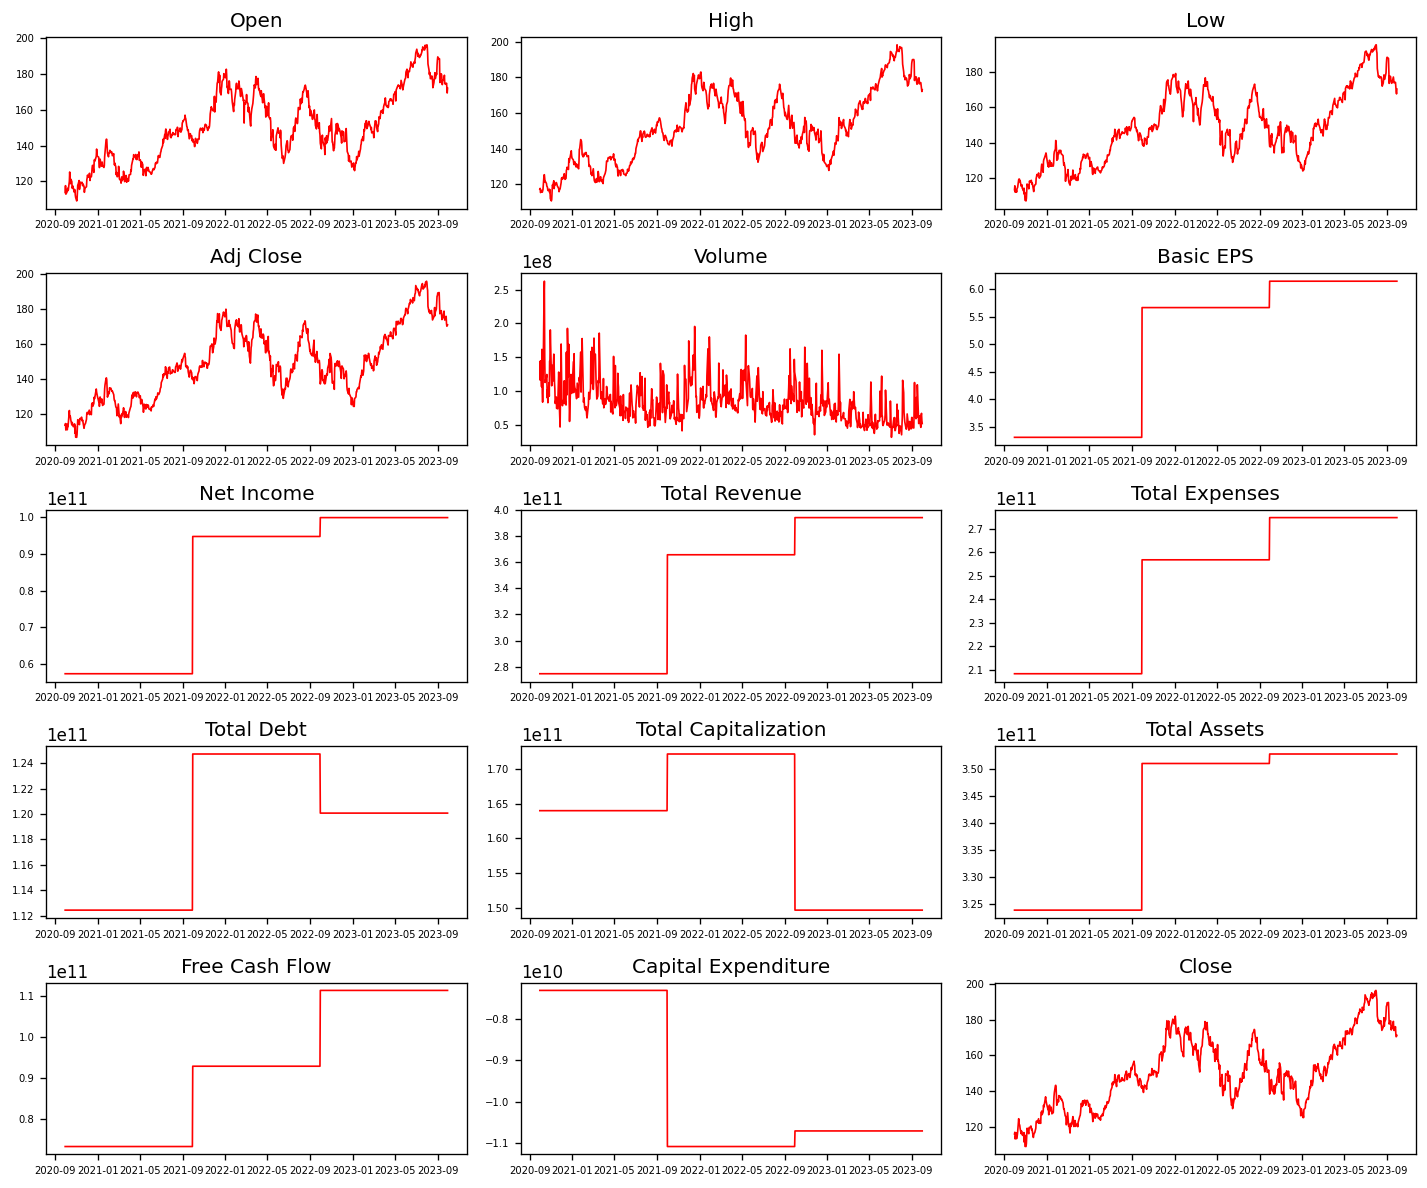

In [31]:
plot_columns(selected_stock_df)

array([[<Axes: title={'center': 'Open'}>,
        <Axes: title={'center': 'High'}>,
        <Axes: title={'center': 'Low'}>,
        <Axes: title={'center': 'Adj Close'}>],
       [<Axes: title={'center': 'Volume'}>,
        <Axes: title={'center': 'Basic EPS'}>,
        <Axes: title={'center': 'Net Income'}>,
        <Axes: title={'center': 'Total Revenue'}>],
       [<Axes: title={'center': 'Total Expenses'}>,
        <Axes: title={'center': 'Total Debt'}>,
        <Axes: title={'center': 'Total Capitalization'}>,
        <Axes: title={'center': 'Total Assets'}>],
       [<Axes: title={'center': 'Free Cash Flow'}>,
        <Axes: title={'center': 'Capital Expenditure'}>,
        <Axes: title={'center': 'Close'}>, <Axes: >]], dtype=object)

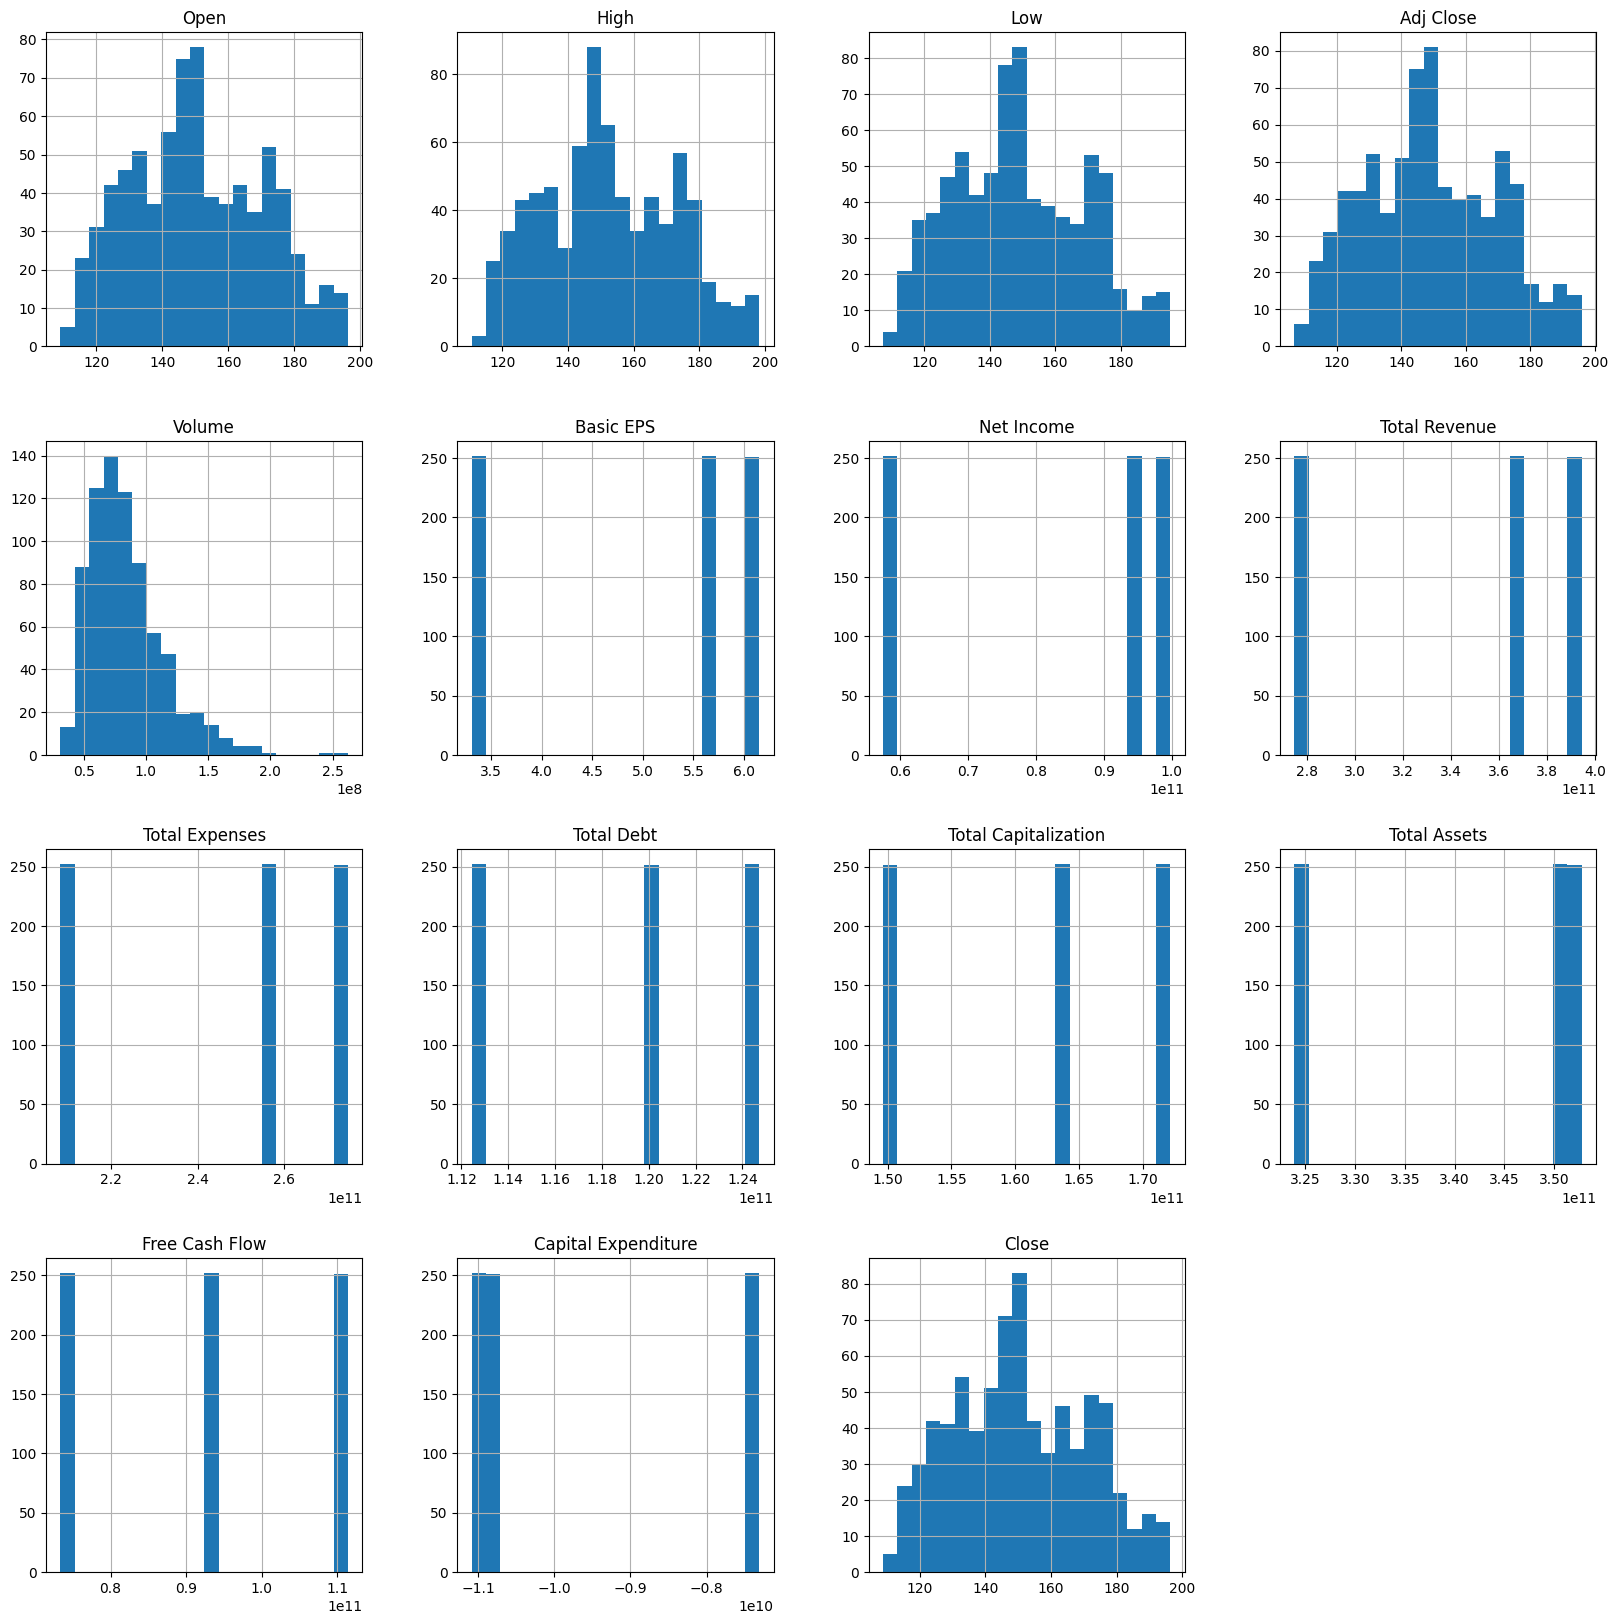

In [32]:
# Plot histograms for all the columns in the Google dataframe
selected_stock_df.hist(bins=20, figsize=(20, 20))

# Bivariate Analysis

## Check if Data is Stationary

In [64]:
def adfuller_test(series, column_name):
    significane_level = 0.05
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{column_name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {significane_level}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= significane_level:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [65]:
df = deepcopy(selected_stock_df)
for name, column in df.items():
    adfuller_test(column, name)
    print('\n')

    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.1894
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.2101. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.038
 No. Lags Chosen       = 1
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.2702. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root

In [66]:
df_differenced = deepcopy(selected_stock_df)
df_differenced = df_differenced.diff().fillna(df_differenced.mean())

In [67]:
# Re-run ADF Test on each column
for name, column in df_differenced.items():
    adfuller_test(column, name)
    print('\n')

    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -60.2976
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -68.112
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05


## Granger’s Causality Test

In [68]:
# The rows of the output are the response variables, while the columns are the predoctors.
# The values are called P-Values, p-value < 0.05 means that X does not cause Y.
def granger_causation_matrix(data):    
    test = 'ssr_chi2test'
    verbose=False
    maxlag=12
    columns = data.columns
    df = pd.DataFrame(np.zeros((len(columns), len(columns))), columns=columns, index=columns)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in columns]
    df.index = [var + '_y' for var in columns]
    return df

granger_causation_matrix(df_differenced) 

,Open_x,High_x,Low_x,Adj Close_x,Basic EPS_x,Net Income_x,Total Revenue_x,Total Expenses_x,Total Debt_x,Total Assets_x,Free Cash Flow_x,Capital Expenditure_x,Close_x
Open_y,1.0000,0.0000,0.0000,0.0000,0.4475,0.3830,0.2213,0.1577,0.0521,0.0596,0.0957,0.2351,0.0000
High_y,0.0002,1.0000,0.0000,0.0000,0.0959,0.0886,0.0623,0.0557,0.0501,0.0514,0.0794,0.0761,0.0000
Low_y,0.0000,0.0000,1.0000,0.0000,0.0159,0.0139,0.0071,0.0058,0.0053,0.0053,0.0103,0.0111,0.0000
Adj Close_y,0.1177,0.1728,0.0859,1.0000,0.3606,0.3438,0.3682,0.3809,0.2310,0.3535,0.2681,0.2830,0.7028
Basic EPS_y,0.6155,0.7470,0.5946,0.5185,1.0000,0.9655,0.9826,0.9819,0.9740,0.9774,0.9984,0.9654,0.5178
Net Income_y,0.6577,0.7959,0.6616,0.5458,0.9654,1.0000,0.9882,0.9857,0.9754,0.9792,0.9968,0.9653,0.5447
Total Revenue_y,0.4421,0.5886,0.4329,0.3919,0.9727,0.9791,1.0000,0.9702,0.9595,0.9635,0.9803,0.9946,0.3922
Total Expenses_y,0.3687,0.5036,0.3417,0.3230,0.9682,0.9727,0.9663,1.0000,0.9548,0.9574,0.9627,0.9925,0.3236
Total Debt_y,0.5581,0.5606,0.4232,0.2157,0.9797,0.9805,0.9773,0.9768,1.0000,0.9917,0.9777,0.9848,0.2159
Total Assets_y,0.5972,0.8014,0.5849,0.4163,0.9654,0.9672,0.9619,0.9600,0.9865,1.0000,0.9586,0.9762,0.4148


## Scatter Plot between features and target

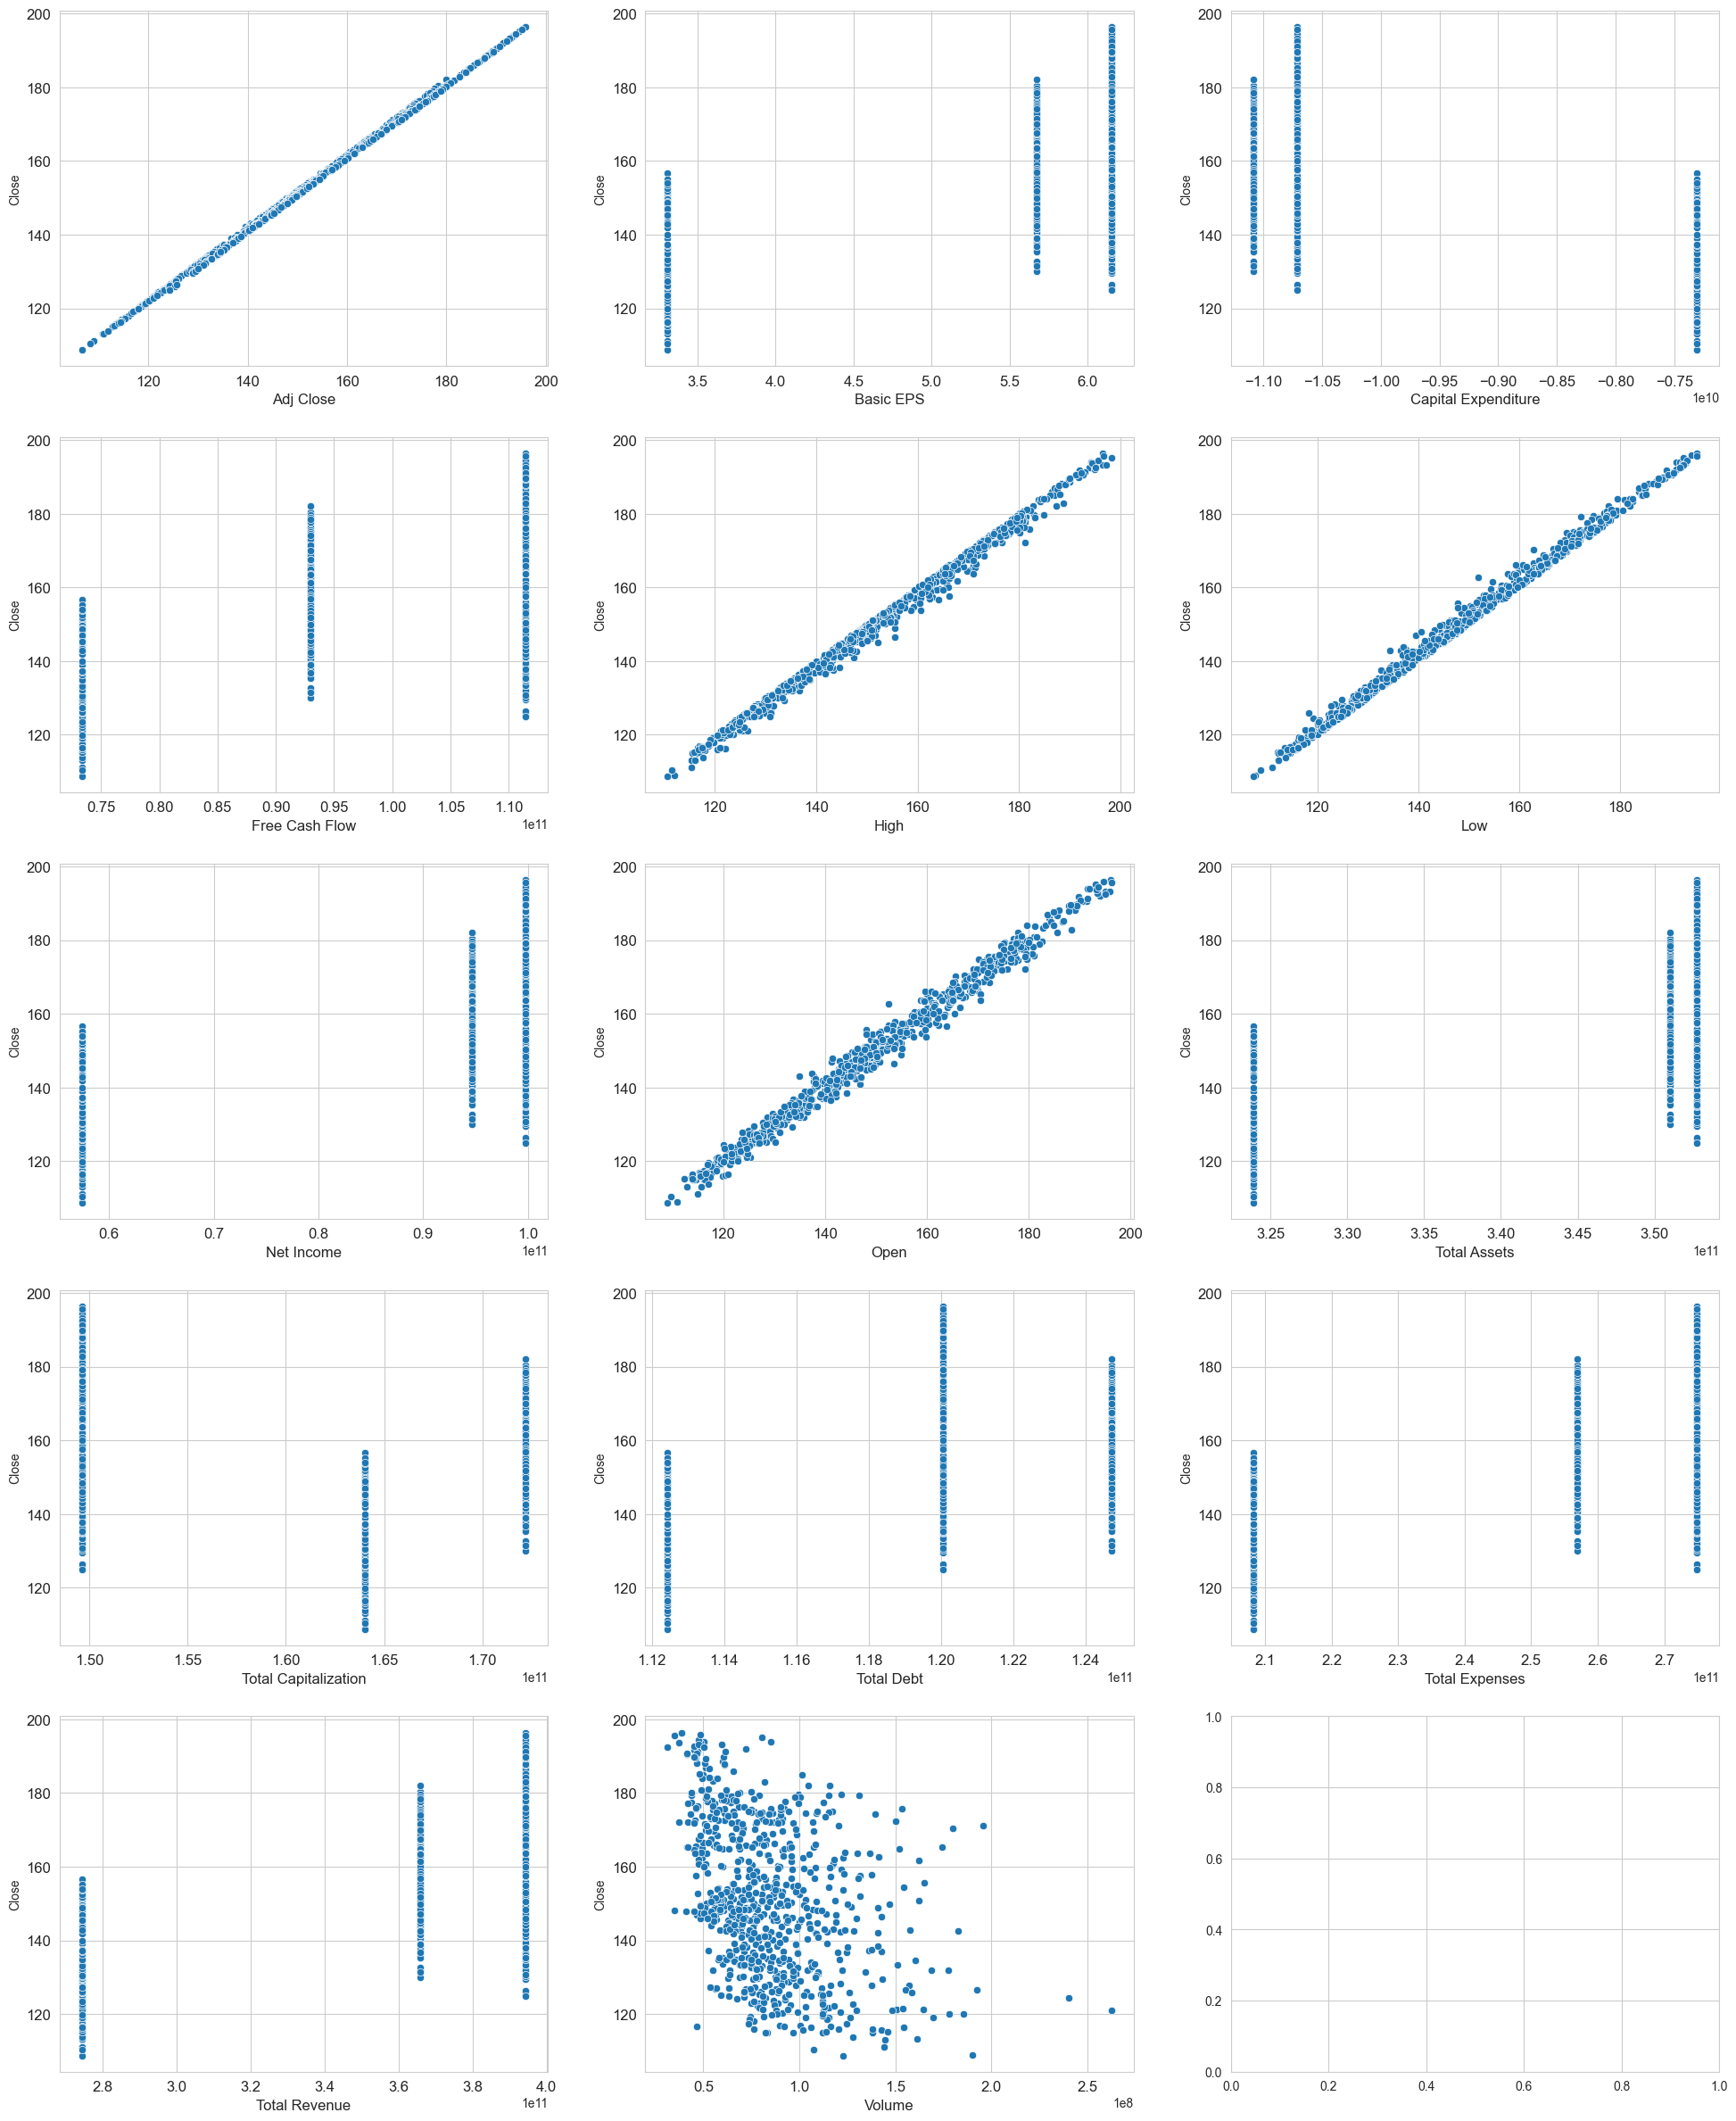

In [34]:
features = selected_stock_df.columns.difference(['Close']).values
i = 0
sns.set_style('whitegrid')
fig, ax = plt.subplots(5,3,figsize=(24,30))

for feature in features:
    i += 1
    plt.subplot(5,3,i)
    sns.scatterplot(x=feature, y='Close', data=selected_stock_df[[feature, 'Close']])
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

# Multivariate Analysis

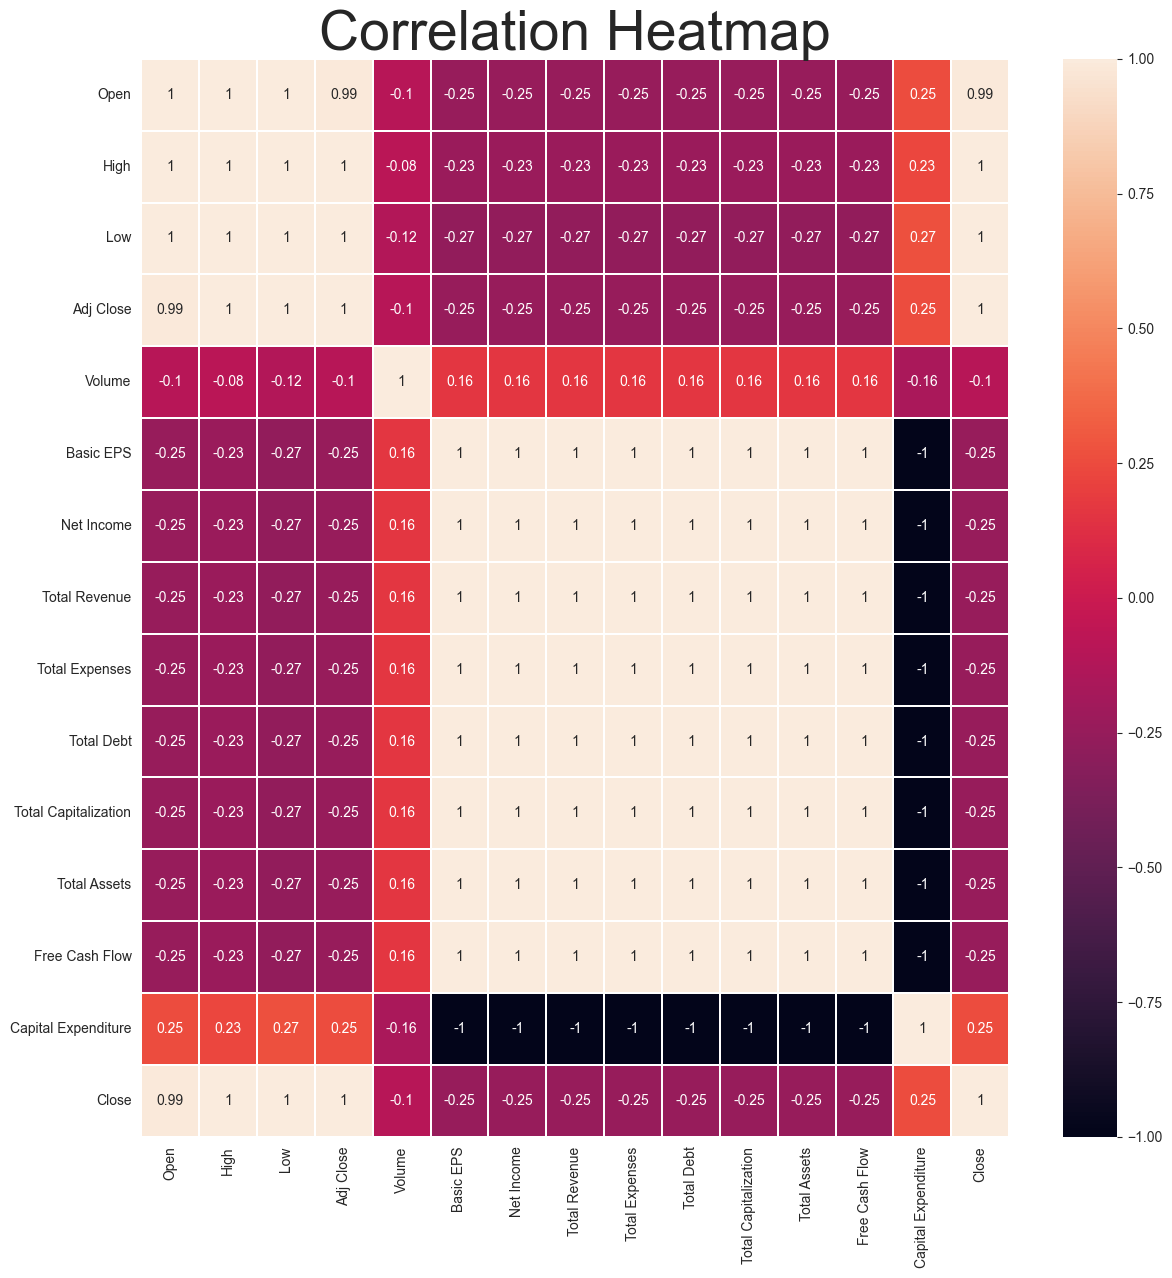

In [34]:
# Correlation between columns using Pearson method
corr = selected_stock_df.corr().round(2)
fig, ax = plt.subplots(figsize=(14,14))
s = sns.heatmap(corr, annot=True, linewidths=0.1, ax=ax)
s.set_title('Correlation Heatmap', fontsize=40)
plt.show()

# Drop columns with correlation coefficient < 0.5

In [35]:
threshold = 0.5
target_column = "Close"
correlation_coefficients = selected_stock_df.corr()[target_column]
columns_to_drop = correlation_coefficients[abs(correlation_coefficients) < threshold].index
selected_stock_df = selected_stock_df.drop(columns=columns_to_drop)

In [36]:
print(selected_stock_df.columns)

Index(['Open', 'High', 'Low', 'Adj Close', 'Basic EPS', 'Net Income',
       'Total Revenue', 'Total Expenses', 'Total Debt', 'Total Capitalization',
       'Total Assets', 'Free Cash Flow', 'Capital Expenditure', 'Close'],
      dtype='object')


# Outliers

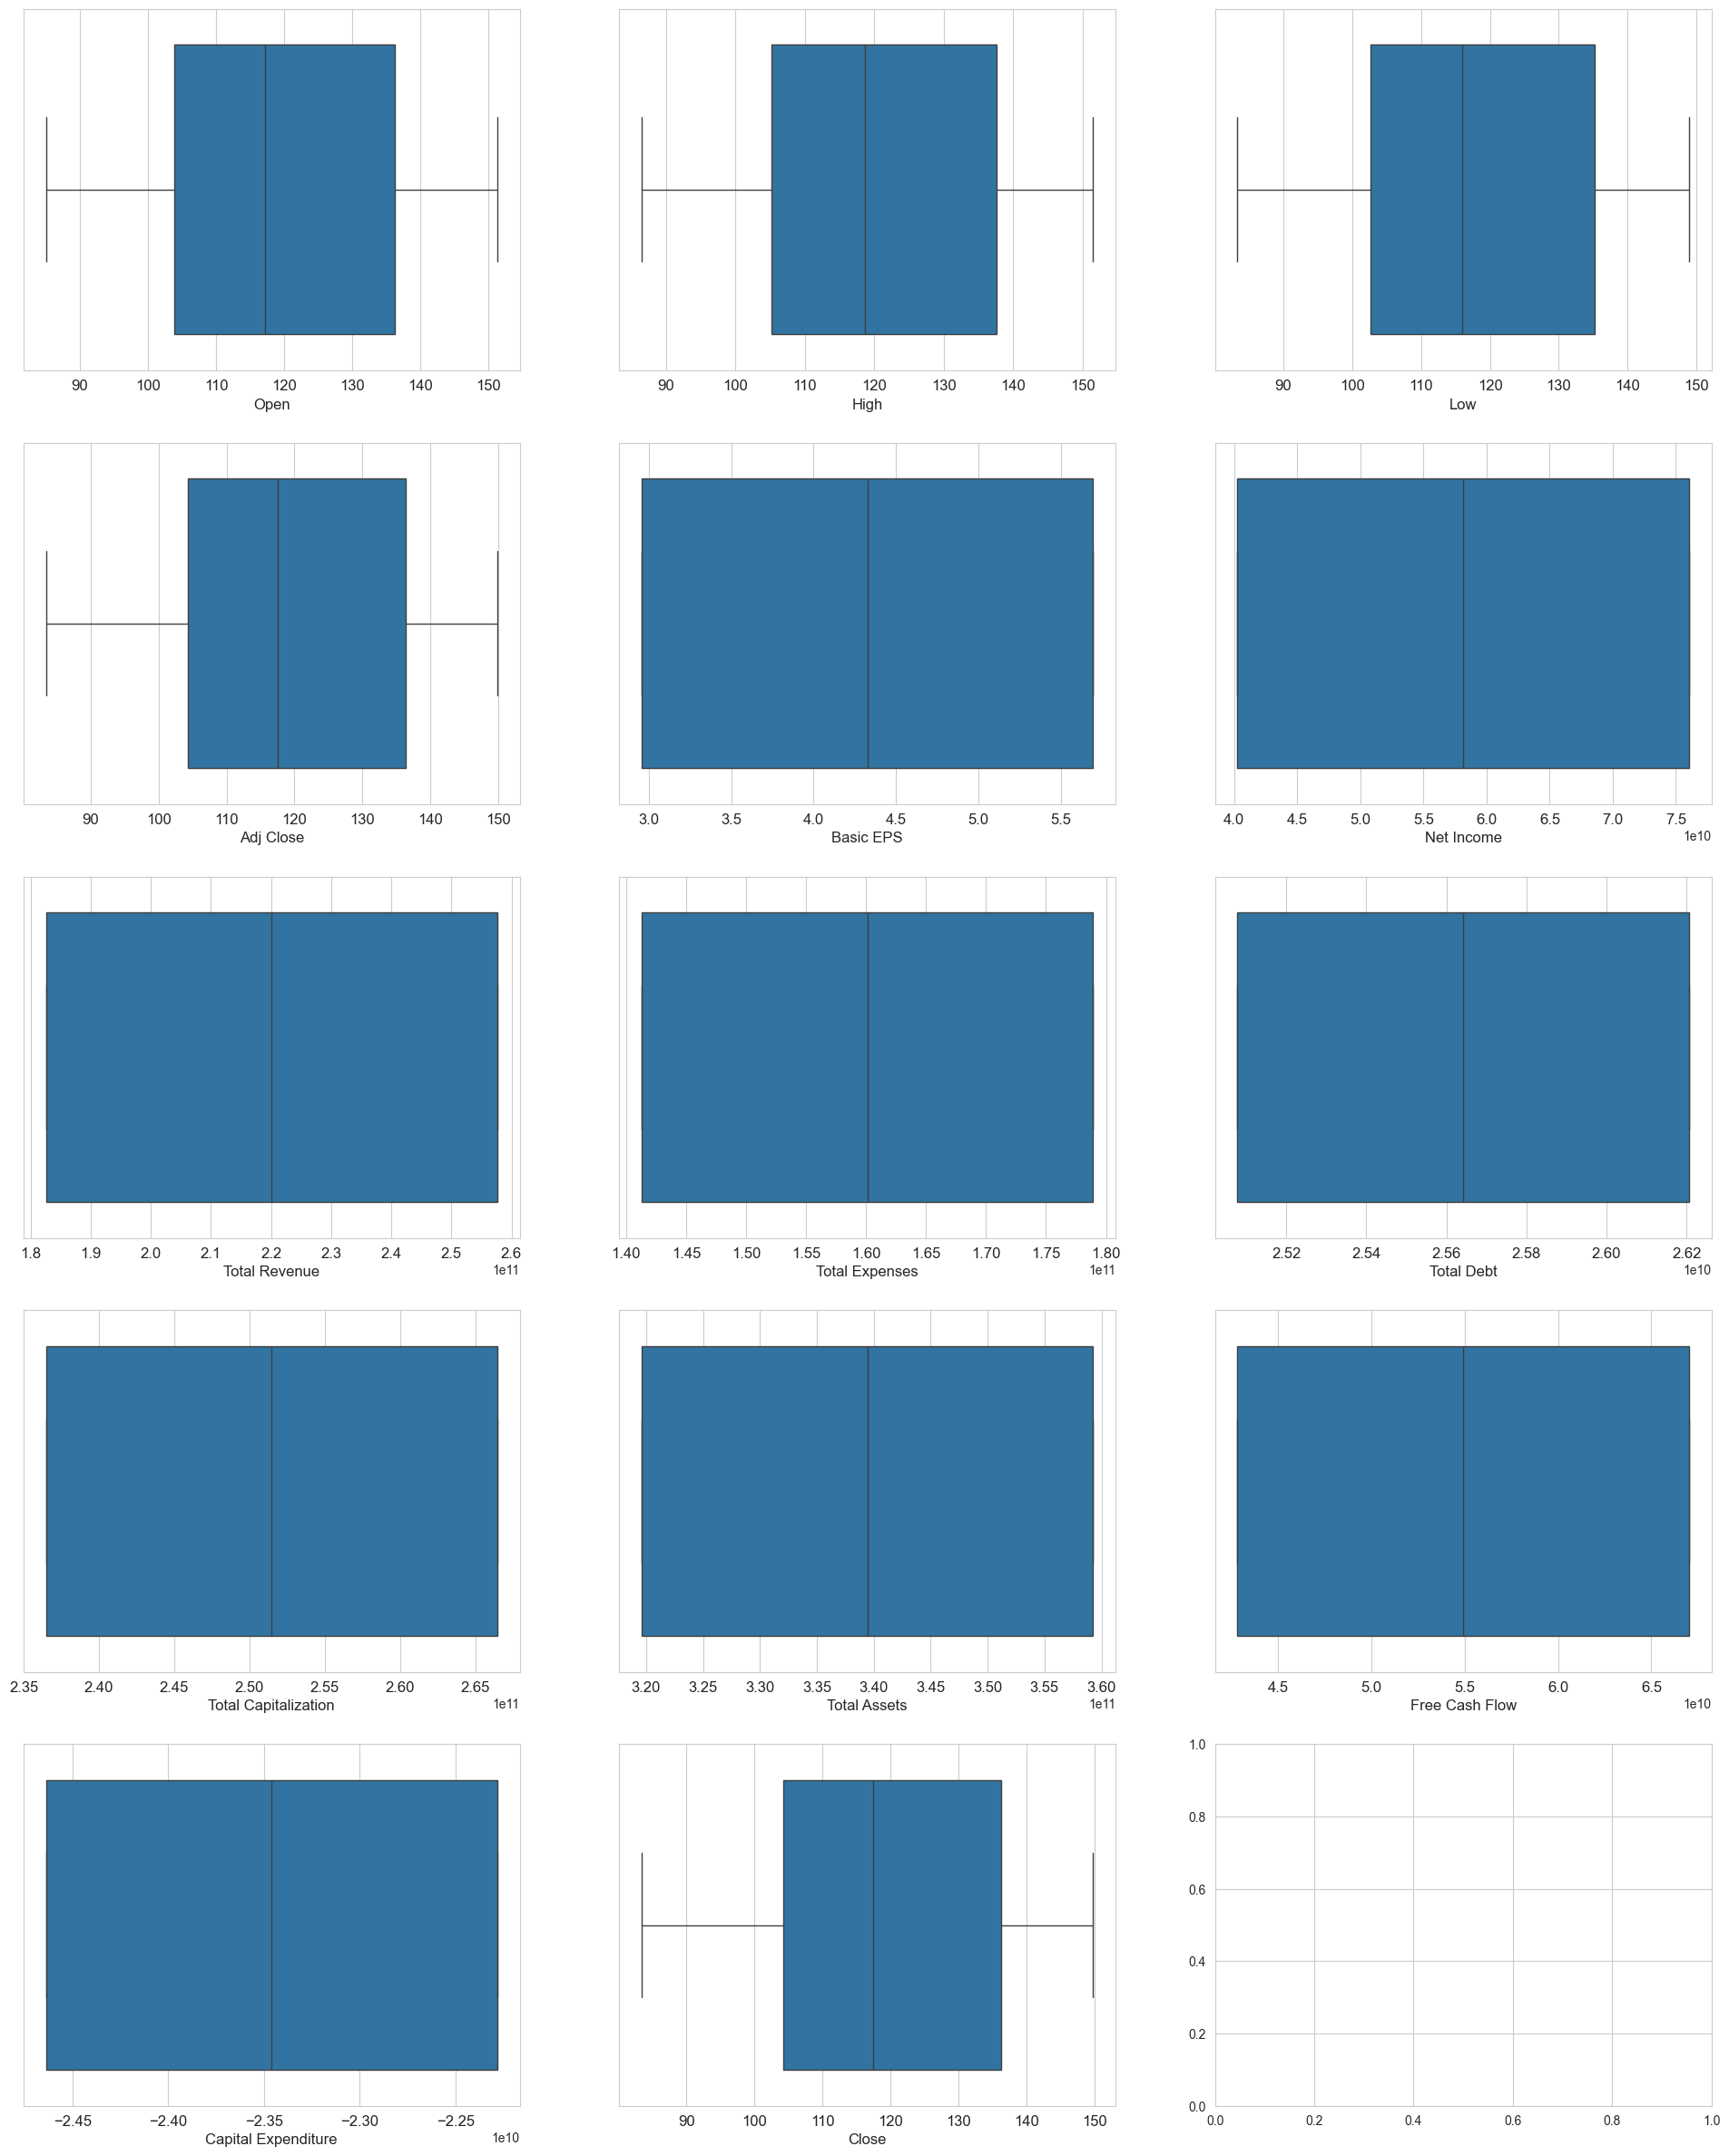

In [37]:
i = 0
sns.set_style('whitegrid')
fig, ax = plt.subplots(5,3,figsize=(24,30))

for column in selected_stock_df:
    i += 1
    plt.subplot(5,3,i)
    sns.boxplot(data=selected_stock_df, x=column)
    plt.xlabel(column, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

In [269]:
# detecting outliers using z-score > ±3
out = selected_stock_df.copy()
out = out.mask(out.sub(out.mean()).div(out.std()).abs().gt(2))
# filling the outliers values
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')
selected_stock_df = pd.DataFrame(mice_imputer.fit_transform(out), columns=out.columns,index=out.index)

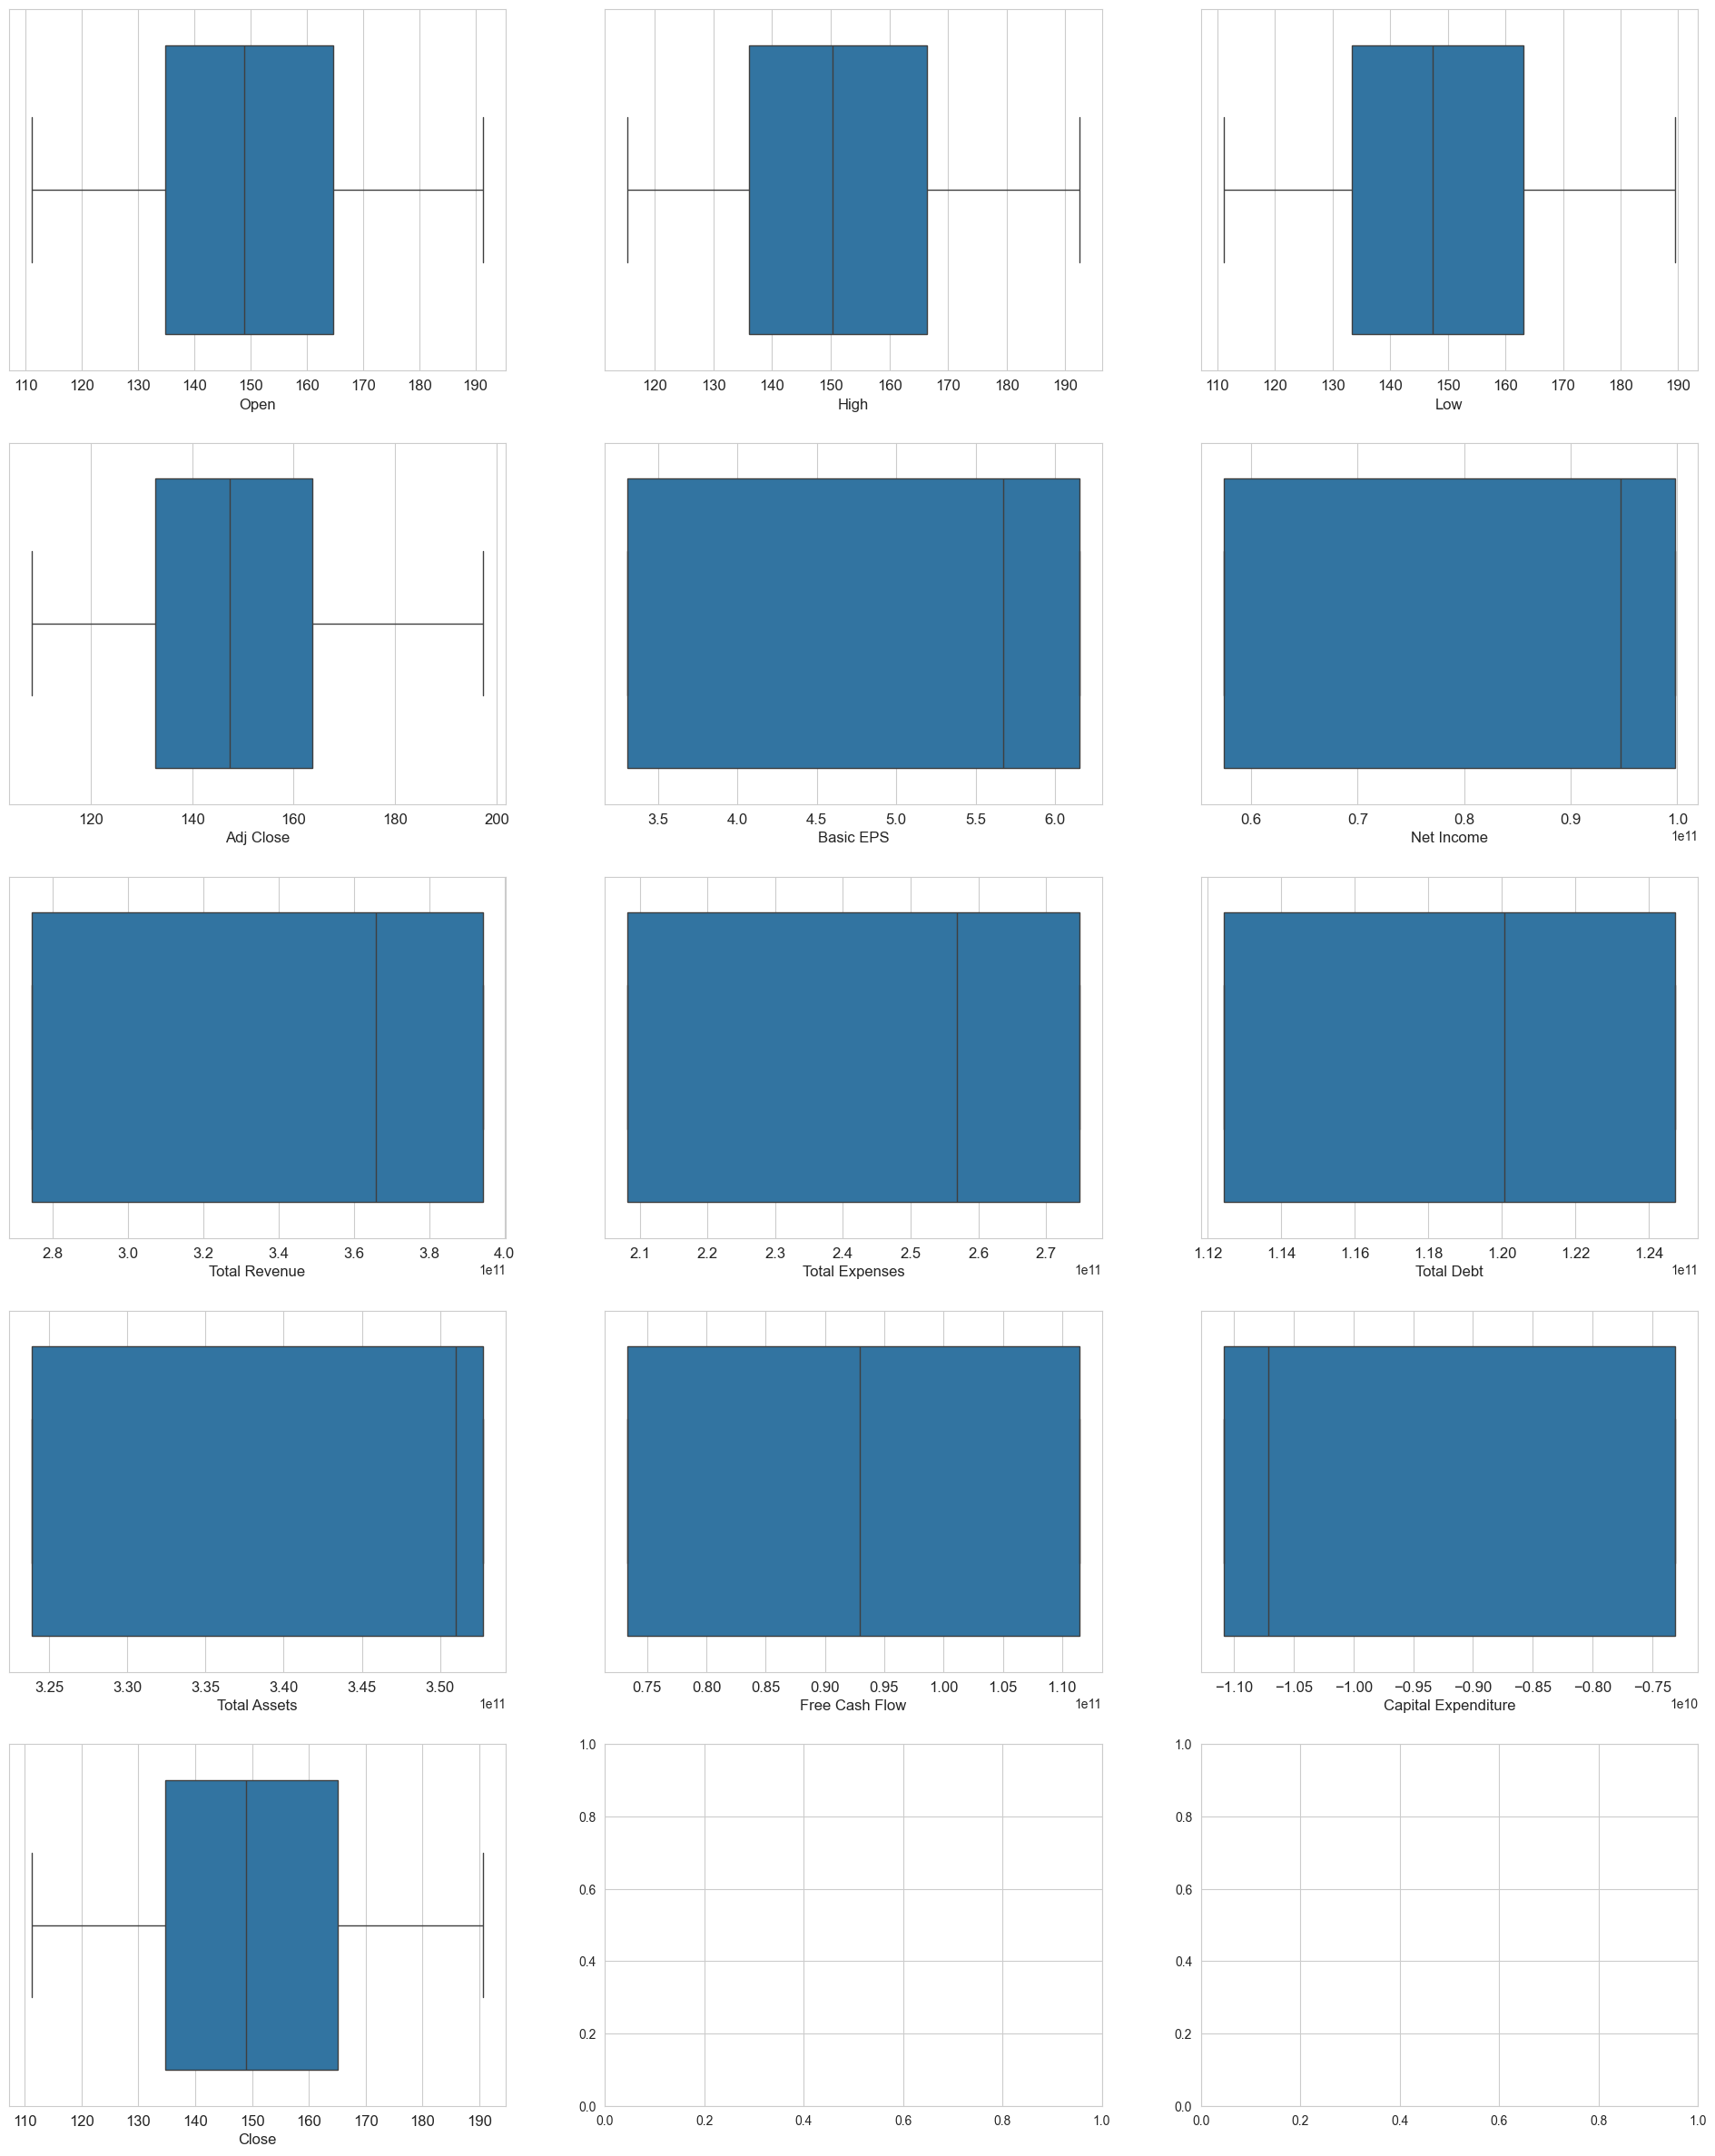

In [270]:
i = 0
sns.set_style('whitegrid')
fig, ax = plt.subplots(5,3,figsize=(24,30))

for column in selected_stock_df:
    i += 1
    plt.subplot(5,3,i)
    sns.boxplot(data=selected_stock_df, x=column)
    plt.xlabel(column, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

# Normalization

In [27]:
def min_max_normalize(df):
  for column in df.columns:
    if column != "Close":
      df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
  return df

In [31]:
# Apply min-max normalization
df_normalized = selected_stock_df.copy()
df_normalized = min_max_normalize(df_normalized)

# SVR Model

## Make prediction for the last 30 days using SVR and Rolling Averages

In [17]:
df = deepcopy(selected_stock_df)
feature_columns = df.columns.difference(["Close"])
target_column = "Close"

In [18]:
# Split data
X = df[feature_columns]
y = df[target_column]
X_train, X_test = X.iloc[:-30], X.iloc[-30:]
y_train, y_test = y.iloc[:-30], y.iloc[-30:]

# Scale features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
# Create and train the SVR model
svr_model = SVR(kernel='poly')
svr_model.fit(X_train_scaled, y_train)

SVR(kernel='poly')

In [20]:
def get_features_for_date(date, window_size):
    # Calculate rolling averages for each feature
    relevant_data = df[df.index >= (date - pd.DateOffset(days=window_size))]
    rolling_averages = relevant_data[feature_columns].mean()
    return rolling_averages.values

In [21]:
# Predicting for the next 30 days
future_dates = X_test.index
window_sizes_to_try = range(1, 31)
best_window_size = None
best_r2 = 0
predictions_df = pd.DataFrame()
warnings.filterwarnings("ignore")
for window_size in window_sizes_to_try:
    predicted_values = []
    for date in future_dates:
        future_features = get_features_for_date(date, window_size)
        future_scaled = scaler.transform([future_features])
        predicted_value = svr_model.predict(future_scaled)
        predicted_values.append(predicted_value[0])

    predictions_df = pd.DataFrame(index=future_dates, data={'Predictions': predicted_values})
    r2 = metrics.r2_score(y_test, predictions_df)
    if r2 > best_r2 and r2 <= 1:
        best_r2 = r2
        best_window_size = window_size

print(f"Best window size: {best_window_size}")
print(f"Best R squared value: {best_r2}")

predicted_values = []
for date in future_dates:
        future_features = get_features_for_date(date, best_window_size)
        future_scaled = scaler.transform([future_features])
        predicted_value = svr_model.predict(future_scaled)
        predicted_values.append(predicted_value[0])

predictions_df = pd.DataFrame(index=future_dates, data={'Predictions': predicted_values})

Best window size: 7
Best R squared value: 0.3099282727065462


In [207]:
# Metrics for Linear SVR Kernel
r2 = metrics.r2_score(y_test, predictions_df)
mse = metrics.mean_squared_error(y_test, predictions_df)
rmse = metrics.mean_squared_error(y_test, predictions_df, squared=False)
mae = metrics.mean_absolute_error(y_test, predictions_df)

print(f"R-Squared: {r2}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")

R-Squared: 0.27862971798063096
Mean Squared Error: 19.710580773757922
Root Mean Squared Error: 4.439659984025569
Mean Absolute Error: 3.0726184244192694


In [22]:
# Metrics for Polynomial SVR Kernel
r2 = metrics.r2_score(y_test, predictions_df)
mse = metrics.mean_squared_error(y_test, predictions_df)
rmse = metrics.mean_squared_error(y_test, predictions_df, squared=False)
mae = metrics.mean_absolute_error(y_test, predictions_df)

print(f"R-Squared: {r2}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")

R-Squared: 0.3099282727065462
Mean Squared Error: 18.855385173933545
Root Mean Squared Error: 4.342278799655032
Mean Absolute Error: 3.0187981547625173


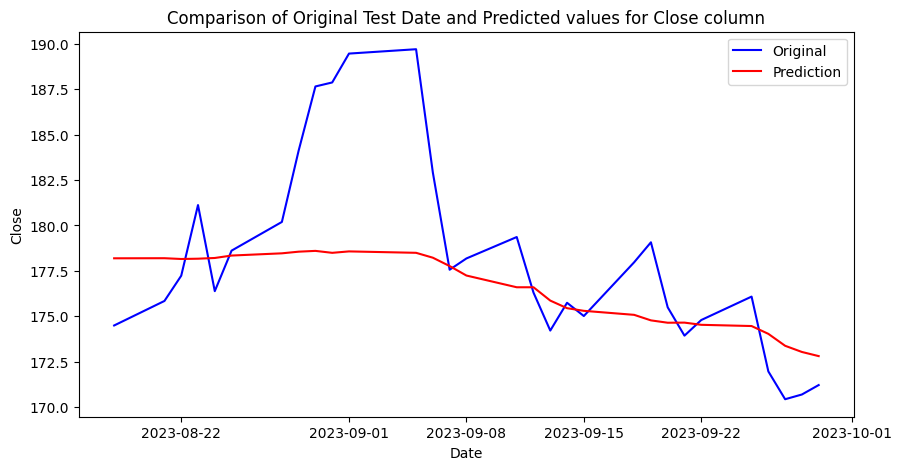

In [23]:
# Plotting the reverse differenced Close column to plot original data
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Original', color='blue')
plt.plot(predictions_df.index, predictions_df, label='Prediction', color='red')

# Customize the plot
plt.title('Comparison of Original Test Date and Predicted values for Close column')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()

# Show the plot
plt.show()

## Make prediction for the next 30 days in the future using SVR and Rolling Averages

In [53]:
df = deepcopy(selected_stock_df)
feature_columns = df.columns.difference(["Close"])
target_column = "Close"

In [54]:
X = df[feature_columns]
y = df[target_column]

# Standardize the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [55]:
# Create and train the SVR model
svr_model = SVR(kernel='poly')
svr_model.fit(X_scaled, y)

SVR(kernel='poly')

In [56]:
def get_features_for_date(date, window_size=30):
    # Calculate rolling averages for each feature
    relevant_data = df[df.index >= (date - pd.DateOffset(days=window_size))]
    rolling_averages = relevant_data[feature_columns].mean()
    return rolling_averages.values

In [57]:
# Predict the target values for the next 30 days
predicted_values = []
warnings.filterwarnings("ignore")
future_dates = pd.date_range(start=df.index.max(), periods=30, freq='D')
for date in future_dates:
    future_features = get_features_for_date(date)
    future_scaled = scaler.transform([future_features])
    predicted_value = svr_model.predict(future_scaled)
    predicted_values.append(predicted_value[0])

predictions_df = pd.DataFrame(index=future_dates, data={'Predictions': predicted_values})

In [49]:
# def get_test_features_for_date(date, window_size):
#     # Calculate rolling averages for each feature
#     relevant_data = df[df.index >= (date - pd.DateOffset(days=window_size))]
#     rolling_averages = relevant_data[feature_columns].mean()
#     return rolling_averages.values

In [50]:
# def get_future_features_for_date(date, window_size):
#     # Calculate rolling averages for each feature
#     relevant_data = df[df.index >= (date - pd.DateOffset(days=window_size))]
#     rolling_averages = relevant_data[feature_columns].mean()
#     new_features = pd.DataFrame(data=[rolling_averages.values], columns=feature_columns, index=[date])
#     df.loc[date, feature_columns] = new_features.values[0]
#     return rolling_averages.values

In [ ]:
# # Predicting for the next 30 days
# X_train, X_test = X.iloc[:-30], X.iloc[-30:]
# y_train, y_test = y.iloc[:-30], y.iloc[-30:]
# test_dates = X_test.index
# window_sizes_to_try = range(1, 31)
# best_window_size = None
# best_r2 = 0
# predictions_df = pd.DataFrame()
# warnings.filterwarnings("ignore")
# for window_size in window_sizes_to_try:
#     predicted_values = []
#     for date in test_dates:
#         future_features = get_test_features_for_date(date, window_size)
#         future_scaled = scaler.transform([future_features])
#         predicted_value = svr_model.predict(future_scaled)
#         predicted_values.append(predicted_value[0])

#     predictions_df = pd.DataFrame(index=test_dates, data={'Predictions': predicted_values})
#     r2 = metrics.r2_score(y_test, predictions_df)
#     if r2 > best_r2 and r2 <= 1:
#         best_r2 = r2
#         best_window_size = window_size

# print(f"Best window size: {best_window_size}")
# print(f"Best R squared value: {best_r2}")

# predicted_values = []
# future_dates = pd.date_range(start=df.index.max(), periods=30, freq='D')
# for date in future_dates:
#         future_features = get_future_features_for_date(date, best_window_size)
#         future_scaled = scaler.transform([future_features])
#         predicted_value = svr_model.predict(future_scaled)
#         predicted_values.append(predicted_value[0])

# predictions_df = pd.DataFrame(index=future_dates, data={'Predictions': predicted_values})

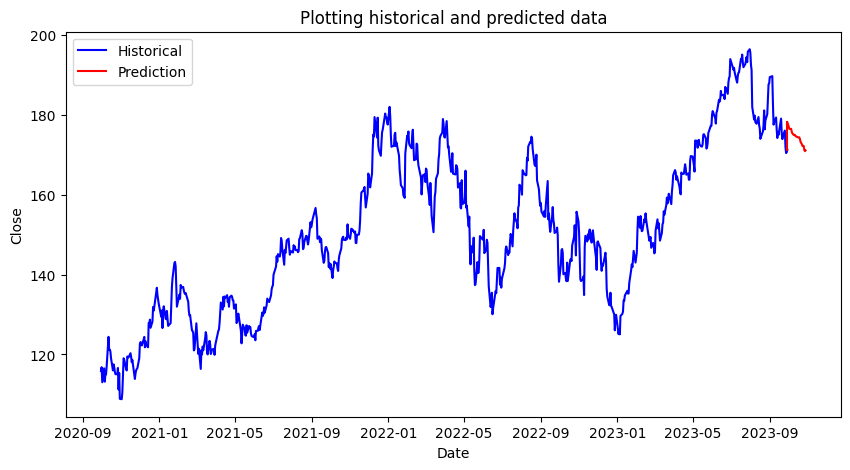

In [58]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(selected_stock_df.index, selected_stock_df["Close"], label="Historical", color="blue")
plt.plot(predictions_df.index, predictions_df["Predictions"], label="Prediction", color="red")

plt.plot([selected_stock_df.index[-1], predictions_df.index[0]], [selected_stock_df["Close"].iloc[-1], predictions_df["Predictions"].iloc[0]], color='red')

# Customize the plot
plt.title("Plotting historical and predicted data")
plt.xlabel("Date")
plt.ylabel("Close")
plt.legend()

# Show the plot
plt.show()